In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# 使用 SAM 自动生成目标掩码

由于 SAM 可以有效地处理提示，因此可以通过对图像上的大量提示进行采样来生成整个图像的掩码。 该方法用于生成数据集 SA-1B。

`SamAutomaticMaskGenerator` 类实现了此功能。 它通过在图像上方的网格中对单点输入提示进行采样来工作，SAM 可以从每个提示中预测多个掩码。 然后，使用非最大抑制对掩码进行质量过滤和重复数据删除。 其他选项允许进一步改进蒙版质量和数量，例如对多个裁剪后的图像进行预测或后处理掩码以删除小的不连接区域和孔洞。

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## 环境搭建

如果使用 jupyter 在本地运行，请首先使用仓库中的[安装说明](https://github.com/facebookresearch/segment-anything#installation) 在您的环境中安装“segment_anything”。 如果从 Google Colab 运行，请在下面设置 using_collab=True 并运行该单元格。 在 Colab 中，请务必在'Edit'->'Notebook Settings'->'Hardware accelerator'下选择“GPU”。

In [3]:
import oneflow.mock_torch as mock
mock.enable(lazy=True, extra_dict={"torchvision": "flowvision"})
using_colab = False

/home/zhangxiaoyu/miniconda3/envs/whisper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## 设置

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
# 这段代码定义了 show_anns() 函数,用于显示图像分割的 annotation(标注)。
# 这行定义函数签名, anns 是包含标注信息的 list。
def show_anns(anns):
    # 这行检查 anns 是否为空,如果为空则返回。
    if len(anns) == 0:
        return
    # 这行根据 anns 中的 area 字段对 anns 进行排序, area 最大的先显示。lambda x: x['area'] 是排序 key 函数。
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    # 这两行获取当前轴 ax,并关闭其自动缩放。
    ax = plt.gca()
    ax.set_autoscale_on(False)
    # 这两行定义 polygons 和 color 列表,用于后续存储多边形和颜色。
    polygons = []
    color = []
    # 这部分循环遍历 sorted_anns, 对每个 ann:
    for ann in sorted_anns:
        # 获取其 segmentation 掩码 m
        m = ann['segmentation']
        # 构造全 1 数组 img 作为底图
        img = np.ones((m.shape[0], m.shape[1], 3))
        # 随机生成颜色color_mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        # 将 img 的 RGB 三个通道设置为 color_mask 的颜色
        for i in range(3):
            img[:,:,i] = color_mask[i]
        # 调用ax.imshow显示img和m的叠加,m透明度为0.35
        ax.imshow(np.dstack((img, m*0.35)))

## 示例图片

In [7]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

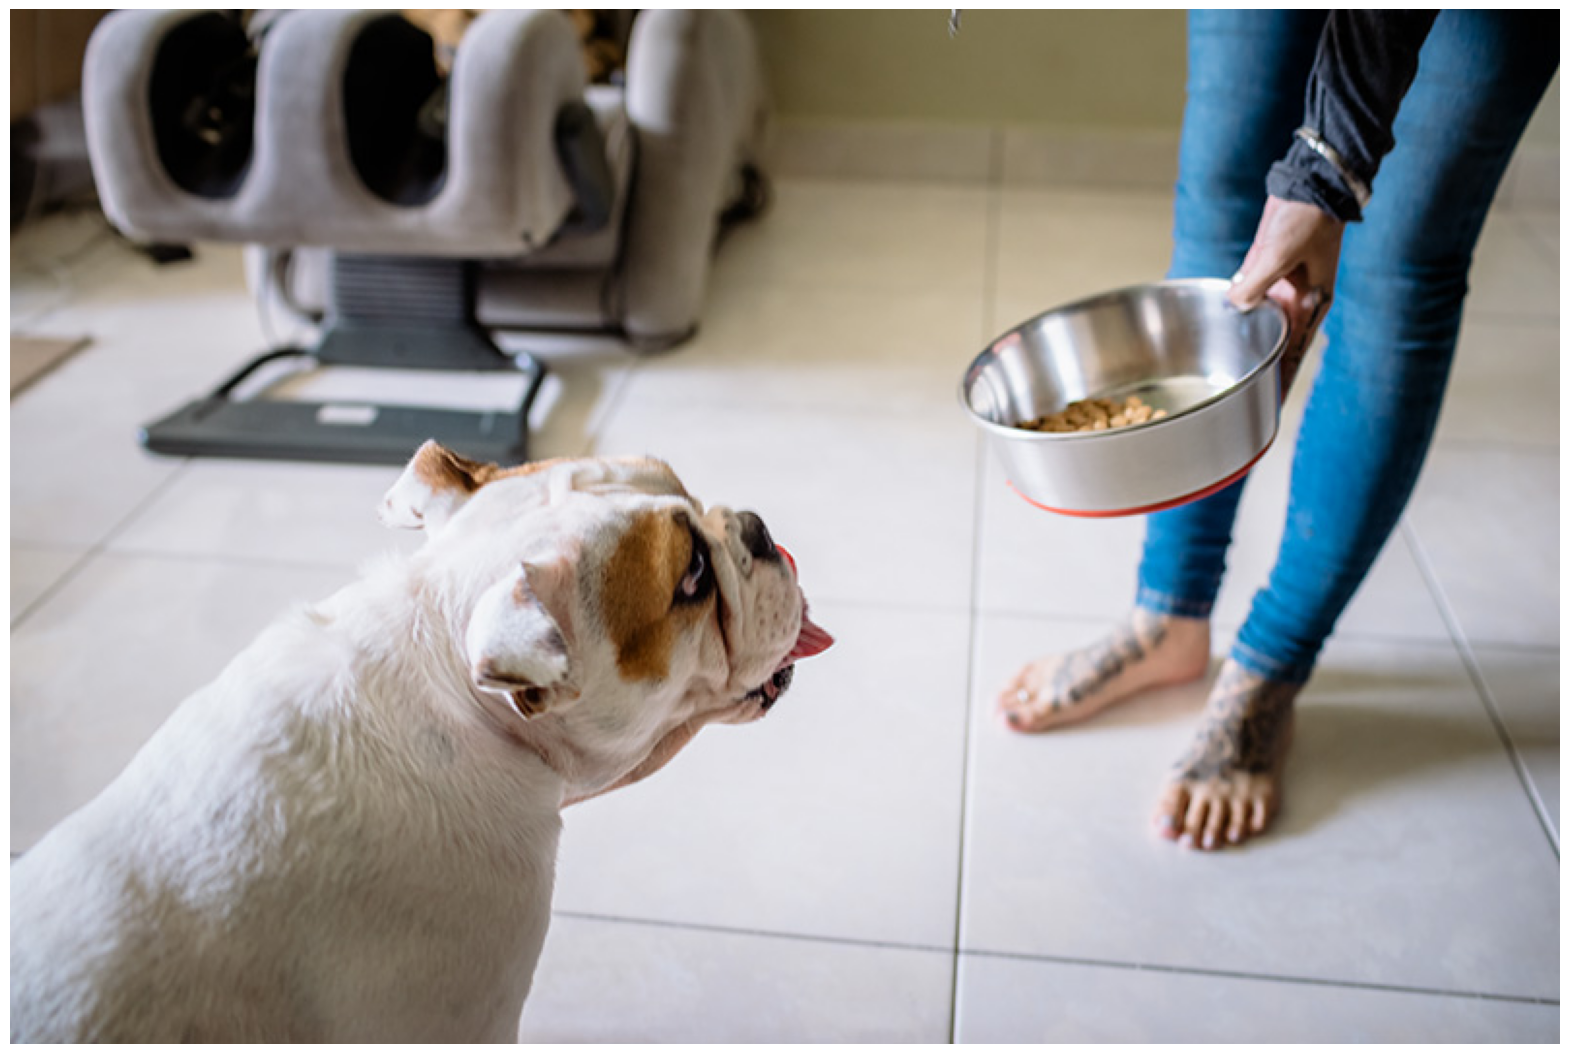

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## 自动掩码生成

要运行自动掩码生成，请向`SamAutomaticMaskGenerator`类提供一个 SAM 模型。 将下面的路径设置为 SAM 权重。 建议在 CUDA 上运行并使用默认模型。

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/home/zhangxiaoyu/segment-anything-model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/zhangxiaoyu/miniconda3/envs/whisper/lib/python3.9/site-packages/oneflow/jit/__init__.py:53: UserWarning: The oneflow.jit._script_if_tracing interface is just to align the torch.jit._script_if_tracing interface and has no practical significance.
  warnings.warn(


要生成掩码，只需在图像上运行 `generate`。

In [10]:
masks = mask_generator.generate(image)

掩码生成返回一个掩码列表，其中每个掩码都是一个包含有关掩码的各种数据的字典。 这些键是：
* `segmentation` : 掩码
* `area` : 掩码的面积（以像素为单位）
* `bbox` : XYWH 格式的掩码边界框
* `predicted_iou` : 模型自己对掩码质量的预测
* `point_coords` : 生成此掩码的采样输入点
* `stability_score` : 掩码质量的额外衡量标准
* `crop_box` : 用于生成 XYWH 格式掩码的裁剪图像

In [11]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


显示覆盖在图像上的所有掩码。

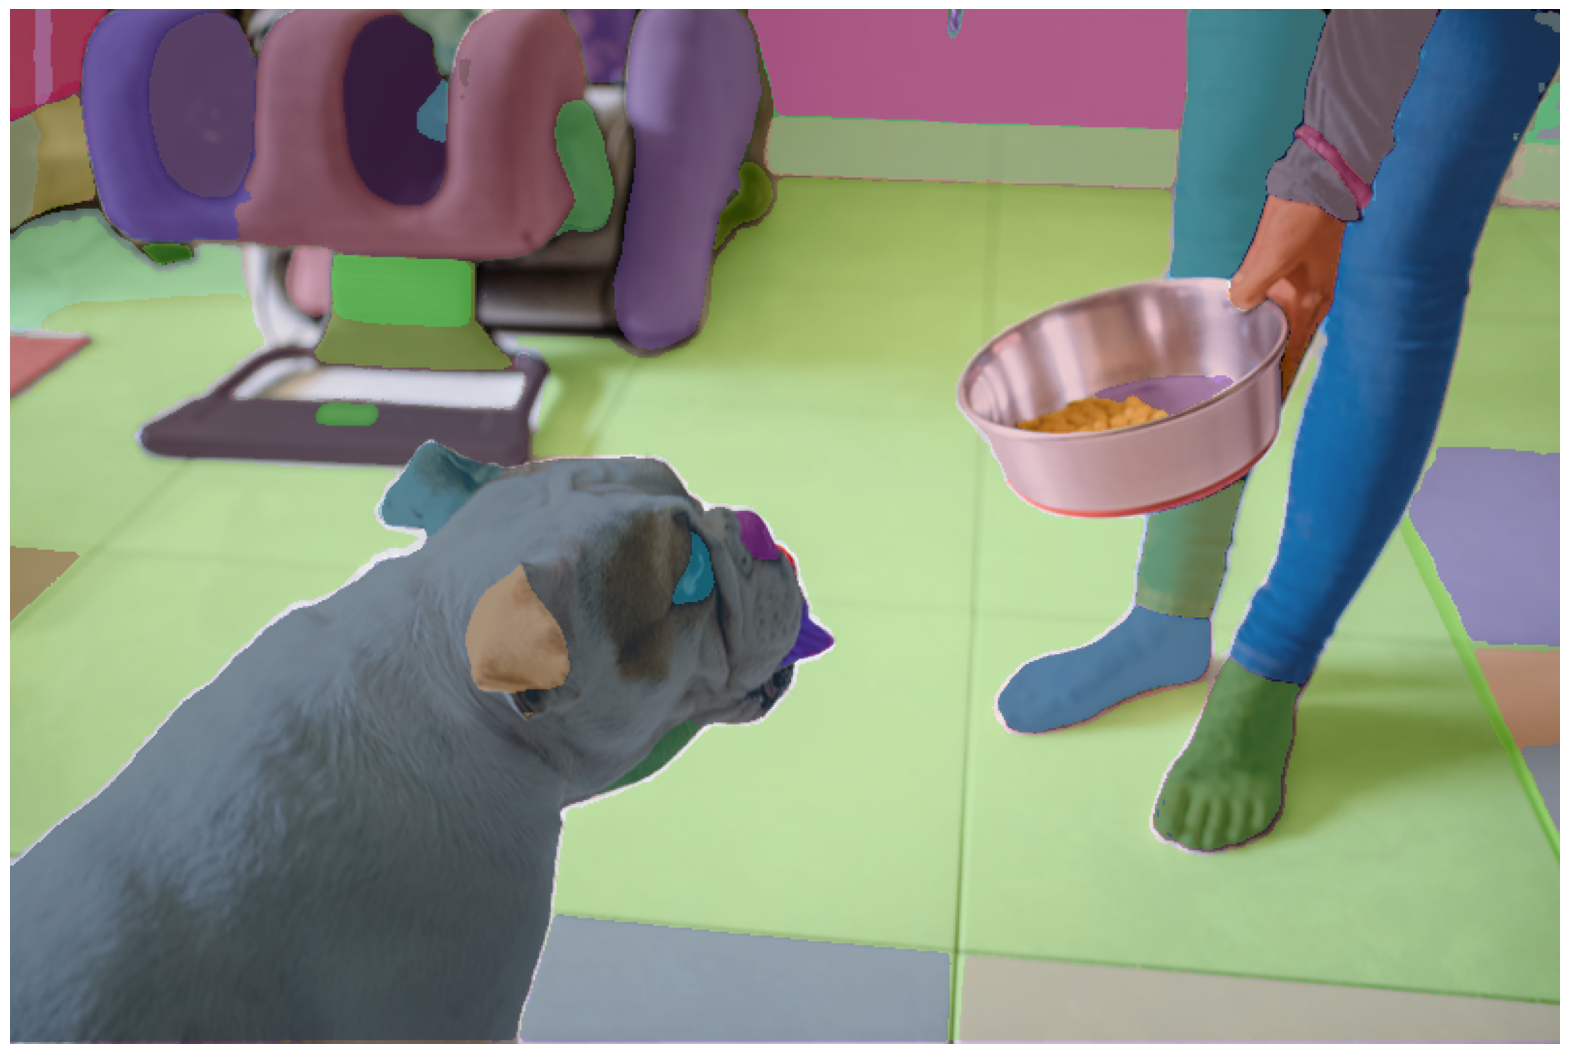

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## 自动掩码生成选项

自动掩码生成中有几个可调参数，用于控制采样点的密度以及去除低质量或重复掩码的阈值。 此外，生成可以在图像的裁剪上自动运行以提高较小对象的性能，并且后处理可以去除杂散像素和孔洞。 以下是对更多掩码进行采样的示例配置：

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [14]:
masks2 = mask_generator_2.generate(image)

In [15]:
len(masks2)

90

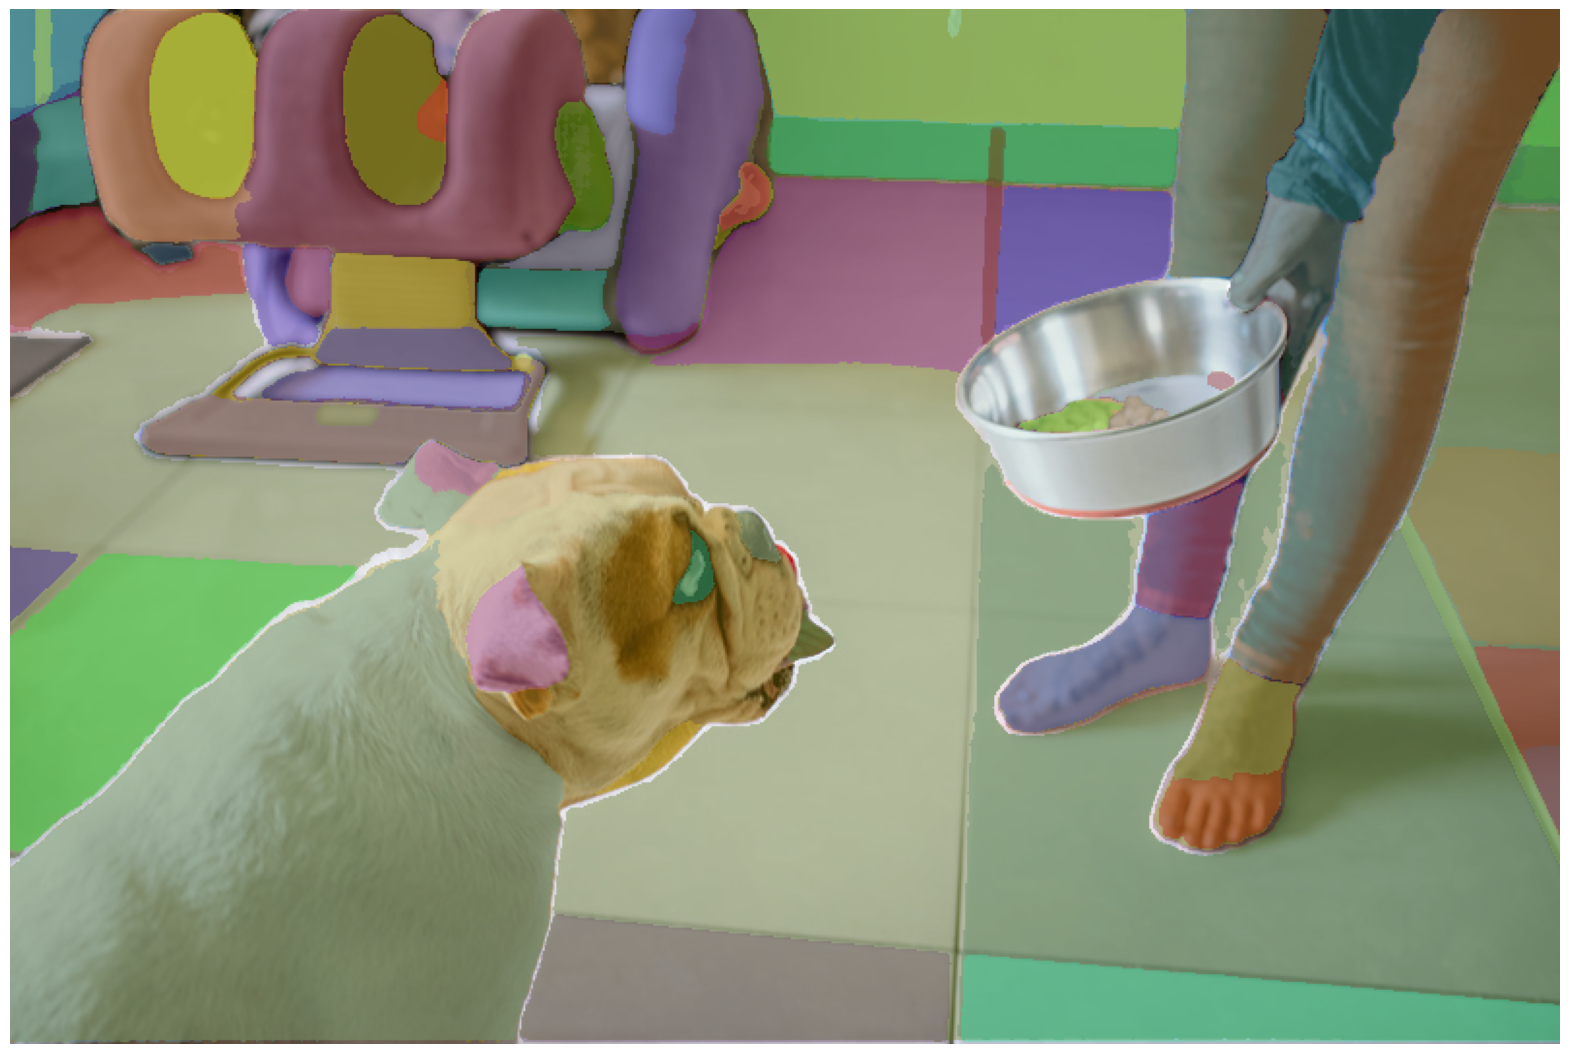

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 